# TopN model + mask generation:
## Purpose: 
## 1. validate that baseline non-linear model has very good topN accuracy
## 2. create masking algorithm for distinguishing specificly top 2 classes 
### a. one mask for each pair - O(nClasses^2) masks
### b. one mask for each class - nClasses masks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from scipy import stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import copy

import Config
from Config import *
import Dataloader as DL
import HD_basis as HDB
import HD_encoder as HDE
import HD_classifier as HDC


In [3]:
# train data. with retrain
def train(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config):
    train_accs = []
    test_accs = []
    for _ in tqdm_notebook(range(param["epochs"]), desc='epochs'):
        train_accs.append(hdc.fit(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    return np.asarray(train_accs), np.asarray(test_accs)

In [4]:
# train data. with retrain
def train_masks(hdc, traindata, trainlabels, testdata, testlabels, param = Config.config):
    train_accs = []
    test_accs = []
    
    for _ in range(5):
        train_accs.append(hdc.fit(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    
    
    print("Train memasks")
    for _ in tqdm_notebook(range(param["epochs"]), desc='epochs'):
        train_accs.append(hdc.fit_mask(traindata, trainlabels, param))
        test_accs.append(hdc.test(testdata, testlabels, param["kernel"]))
        if len(train_accs) % 5 == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
        if train_accs[-1] == 1:
            print("Train: %f \t \t Test: %f"%(train_accs[-1], test_accs[-1]))
            break
    return np.asarray(train_accs), np.asarray(test_accs)

In [25]:
def show_plots(fst_scs, snd_scs, pairs = None):
    
    new_fst = []
    new_snd = []
    
    if pairs is not None:
        for sc in fst_scs:
            if (sc[3], sc[4]) in pairs or (int(sc[4]), int(sc[3])) in pairs:
                new_fst.append(sc)
        for sc in snd_scs:
            if (sc[3], sc[4]) in pairs or (int(sc[4]), int(sc[3])) in pairs:
                new_snd.append(sc)          
        fst_scs = np.asarray(new_fst)
        snd_scs = np.asarray(new_snd)
    
    rg = [min(np.min(fst_scs[:,:2]), np.min(snd_scs[:,:2])), 
          max(np.max(fst_scs[:,:2]), np.max(snd_scs[:,:2]))]
    
    # Scatter plots
    plt.figure(figsize = (10, 10))
    plt.plot(rg, rg, ls = "--")
    plt.scatter(fst_scs[:,0], fst_scs[:,1], label = "fst", color = "g", alpha = 0.7, s = 16)
    plt.legend()
    plt.show()

    plt.figure(figsize = (10, 10))
    plt.plot(rg, rg, ls = "--")
    plt.scatter(snd_scs[:,0], snd_scs[:,1], label = "snd", color = "r", alpha = 0.7, s = 16)
    plt.legend()
    plt.show()

    plt.figure(figsize = (10, 10))
    plt.plot(rg, rg, ls = "--")
    plt.scatter(fst_scs[:,0], fst_scs[:,1], label = "fst", color = "g", alpha = 0.3, s = 16)
    plt.scatter(snd_scs[:,0], snd_scs[:,1], label = "snd", color = "r", alpha = 0.3, s = 16)
    plt.legend()
    plt.show()
    
    # ratio dist
    fst_rt = fst_scs[:,0]/fst_scs[:,1]
    snd_rt = snd_scs[:,0]/snd_scs[:,1]

    # Exclude but record outliers 
    sd = np.std(np.append(fst_rt, snd_rt))
    mn = np.mean(np.append(fst_rt, snd_rt))
    z = 2
    print(sd, mn)
    fst_rt_ol = fst_rt[np.abs(fst_rt - mn) > 2 * z * sd]
    fst_rt_cl = fst_rt[np.abs(fst_rt - mn) <= 2 * z * sd]
    snd_rt_ol = snd_rt[np.abs(snd_rt - mn) > 2 * z * sd]
    snd_rt_cl = snd_rt[np.abs(snd_rt - mn) <= 2 * z * sd]

    # Ratio dist, deprecated because it doesn't make sense
    #plt.figure(figsize = (50, 20))
    #plt.hist(fst_rt_cl, bins = 200, label = "fst", color = "r", alpha = 0.5)
    #plt.hist(snd_rt_cl, bins = 200, label = "snd", color = "g", alpha = 0.5)
    #plt.legend(prop={"size":80})
    
    # diff dist
    fst_sc = fst_scs[:,0]-fst_scs[:,1]
    snd_sc = snd_scs[:,0]-snd_scs[:,1]
    plt.figure(figsize = (50, 20))
    plt.hist(fst_sc, bins = 200, label = "fst", color = "r", alpha = 0.5)
    plt.hist(snd_sc, bins = 200, label = "snd", color = "g", alpha = 0.5)
    plt.legend(prop={"size":80})

In [6]:
dl = DL.Dataloader()
nFeatures, nClasses, traindata, trainlabels, testdata, testlabels = dl.getParam()


Loading dataset UCIHAR from UCIHAR
Loading train data... train data of shape (6213, 561) loaded
Loading test data...  test  data of shape (1554, 561) loaded
Data Loaded. Num of features = 561 Num of Classes = 12

In [7]:
#Data shuffling 
shuf_train = np.random.permutation(len(traindata))
traindata = traindata[shuf_train]
trainlabels = trainlabels[shuf_train]

shuf_test = np.random.permutation(len(testdata))
testdata = testdata[shuf_test]
testlabels = testlabels[shuf_test]

In [8]:
traindata = traindata[:10000]
testdata = testdata[:5000]

In [9]:
param = Config.config
param["nFeatures"] = nFeatures
param["nClasses"] = nClasses
print(param)

{'data_location': '../dataset/', 'directory': 'UCIHAR', 'dataset': 'UCIHAR', 'D': 100, 'vector': 'Gaussian', 'mu': 0, 'sigma': 1, 'binarize': 0, 'lr': 1, 'sparse': 0, 's': 0.1, 'binaryModel': 0, 'checkpoints': False, 'kernel': <Kernel_T.COS: 1>, 'width': None, 'height': None, 'nLayers': 5, 'uniform_dim': 1, 'uniform_ker': 1, 'dArr': None, 'k': 3, 'kArr': None, 'one_shot': 0, 'data_percentages': [1.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 'train_percent': 1, 'dropout': 0, 'drop_percentages': [0, 0.1, 0.2, 0.5], 'dropout_rate': 0, 'update_type': <Update_T.FULL: 1>, 'iter_per_trial': 3, 'iter_per_encoding': 5, 'epochs': 100, 'nFeatures': 561, 'nClasses': 12}


# Sample code to train a model

In [15]:
################# VANILLA #################
hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
basis = hdb.getBasis()
bid = hdb.getParam()["id"]
# Update param with bid
param = hdb.getParam()
print(bid)

Generating vanilla HD basis of shape... 


9238


(200, 561)
Encoding time: 0.02689337730407715 


In [16]:
# Retrieve info upto basis generator, given correct bid
#bid = 6679
#basis, param = HDB.loadBasis("base_%d.pkl"%bid)

In [17]:
hde = HDE.HD_encoder(basis)

trainencoded = hde.encodeData(traindata)
#HDE.saveEncoded(trainencoded, trainlabels, bid, "train")

testencoded = hde.encodeData(testdata)
#HDE.saveEncoded(testencoded, testlabels, bid, "test")

Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec


In [18]:
# Retrieve info upto encoder, given correct bid
#bid = 6679
#basis, param = HDB.loadBasis("base_%d.pkl"%bid)
#trainencoded, trainlabels = HDE.loadEncoded("encoded_%d_train.pkl"%bid)
#testencoded, testlabels = HDE.loadEncoded("encoded_%d_test.pkl"%bid)

In [19]:
hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.COS: 1>)] 


Train: 0.721552 	 	 Test: 0.428571
Train: 0.878320 	 	 Test: 0.822394
Train: 0.908418 	 	 Test: 0.922780
Train: 0.920650 	 	 Test: 0.945946
Train: 0.935458 	 	 Test: 0.938867
Train: 0.940286 	 	 Test: 0.920849
Train: 0.950427 	 	 Test: 0.923423
Train: 0.954772 	 	 Test: 0.940798
Train: 0.951392 	 	 Test: 0.948520
Train: 0.956704 	 	 Test: 0.953668
Train: 0.959440 	 	 Test: 0.951737
Train: 0.961532 	 	 Test: 0.922136
Train: 0.961532 	 	 Test: 0.941441
Train: 0.961532 	 	 Test: 0.958172
Train: 0.958796 	 	 Test: 0.957529
Train: 0.968453 	 	 Test: 0.957529



# Top n accuracy

In [10]:
def topn_suit(traindata, trainlabels, testdata, testlabels, param):
    hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
    basis = hdb.getBasis()
    bid = hdb.getParam()["id"]
    param = hdb.getParam()
    
    hde = HDE.HD_encoder(basis)
    trainencoded = hde.encodeData(traindata)
    testencoded = hde.encodeData(testdata)
    
    hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
    train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)
    accs = []
    cmps = []
    for k in range(5):
        accs.append(hdc.test_topn(testencoded, testlabels, k+1))
        cmps.append(hdc.predict_topn(testencoded, k+1))
        print("Top %d accuracy: "%(k+1), accs[-1])
    return accs, cmps

In [ ]:
Ds = [200, 500, 1000]
accs_D = dict()
cmps_D = dict()
for D in Ds:
    param["D"] = D
    accs_D[D], cmps_D[D] = topn_suit(traindata, trainlabels, testdata, testlabels, param)
param["D"] = Config.config["D"]

Generating vanilla HD basis of shape... 

(200, 561)
Encoding time: 0.031884193420410156 
Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Train: 0.721713 	 	 Test: 0.809524


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.DOT: 0>)] 


Train: 0.891196 	 	 Test: 0.879022
Train: 0.914695 	 	 Test: 0.936937
Train: 0.919202 	 	 Test: 0.933076


In [ ]:
for D in accs_D.keys():
    print(D)
    for i in range(len(accs_D[D])):
        print("Top %d Accuracy:"%(i+1), accs_D[D][i])

# Mask generation: 2d masks

In [10]:
hdb = HDB.HD_basis(Config.Generator_T.Vanilla, param)
basis = hdb.getBasis()
bid = hdb.getParam()["id"]
param = hdb.getParam()

hde = HDE.HD_encoder(basis)
trainencoded = hde.encodeData(traindata)
testencoded = hde.encodeData(testdata)

hdc = HDC.HD_classifier(param["D"], param["nClasses"], bid)
#train_acc, test_acc = train_masks(hdc, trainencoded, trainlabels, testencoded, testlabels, param)
train_acc, test_acc = train(hdc, trainencoded, trainlabels, testencoded, testlabels, param)
hdc.normalizeClasses()
acc_1 = hdc.test(testencoded, testlabels, param["kernel"])
acc_2 = hdc.test_topn(testencoded, testlabels, 2)
print("Normalized top1 and top 2 test accuracy:", acc_1, acc_2)

Generating vanilla HD basis of shape... 

(100, 561)
Encoding time: 0.03043961524963379 
Encoding data of shape (6213, 561)


Time spent: 0 sec
Encoding data of shape (1554, 561)


Time spent: 0 sec
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Fitting with configuration: [('one_shot', 0), ('dropout', 0), ('lr', 1), ('kernel', <Kernel_T.COS: 1>)] 


Train: 0.726863 	 	 Test: 0.725225
Train: 0.889747 	 	 Test: 0.882239
Train: 0.905682 	 	 Test: 0.931789
Train: 0.913407 	 	 Test: 0.900257
Train: 0.921294 	 	 Test: 0.909910
Train: 0.920650 	 	 Test: 0.918275
Train: 0.929020 	 	 Test: 0.848777
Train: 0.933687 	 	 Test: 0.874517
Train: 0.930307 	 	 Test: 0.916988
Train: 0.938677 	 	 Test: 0.940154
Train: 0.937550 	 	 Test: 0.857786
Train: 0.943345 	 	 Test: 0.893179
Train: 0.947368 	 	 Test: 0.925354
Train: 0.945437 	 	 Test: 0.937580
Train: 0.941413 	 	 Test: 0.921493
Train: 0.945759 	 	 Test: 0.942728
Train: 0.943184 	 	 Test: 0.942728
Train: 0.942218 	 	 Test: 0.929215
Train: 0.944632 	 	 Test: 0.906049
Train: 0.948173 	 	 Test: 0.895109

Normalized top1 and top 2 test accuracy: 0.8577863577863578 0.990990990990991


Len of fst, snd:  5400 813
Len of fst after cropping:  4987


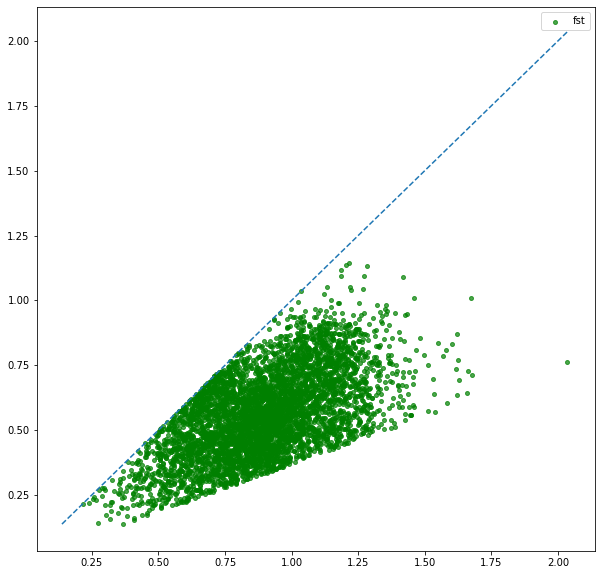

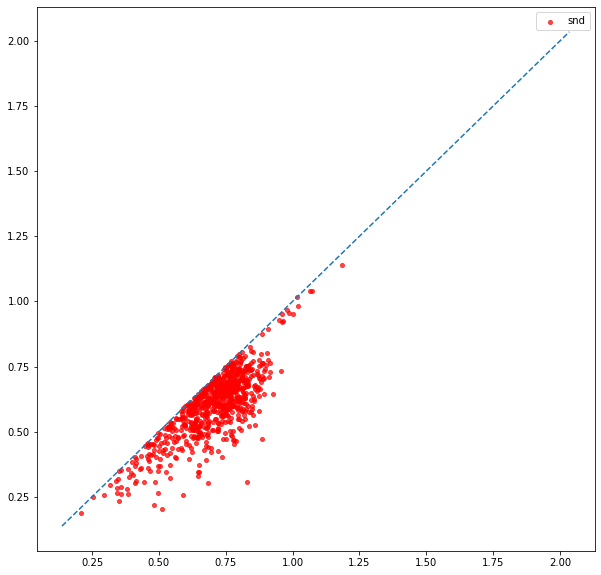

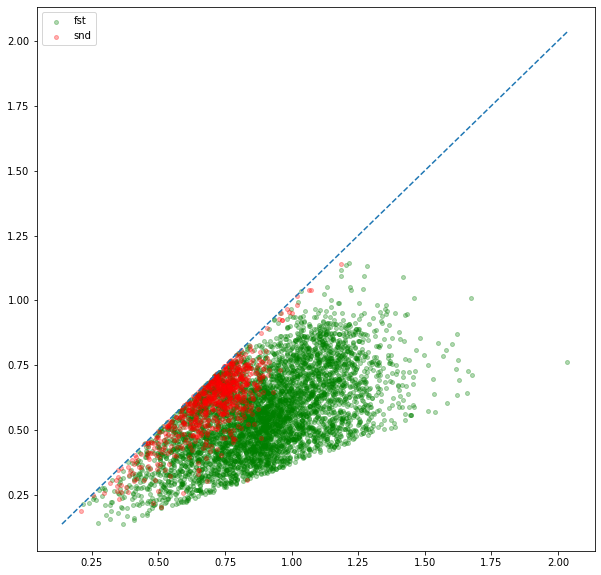

0.425316187801641 1.599705476000485


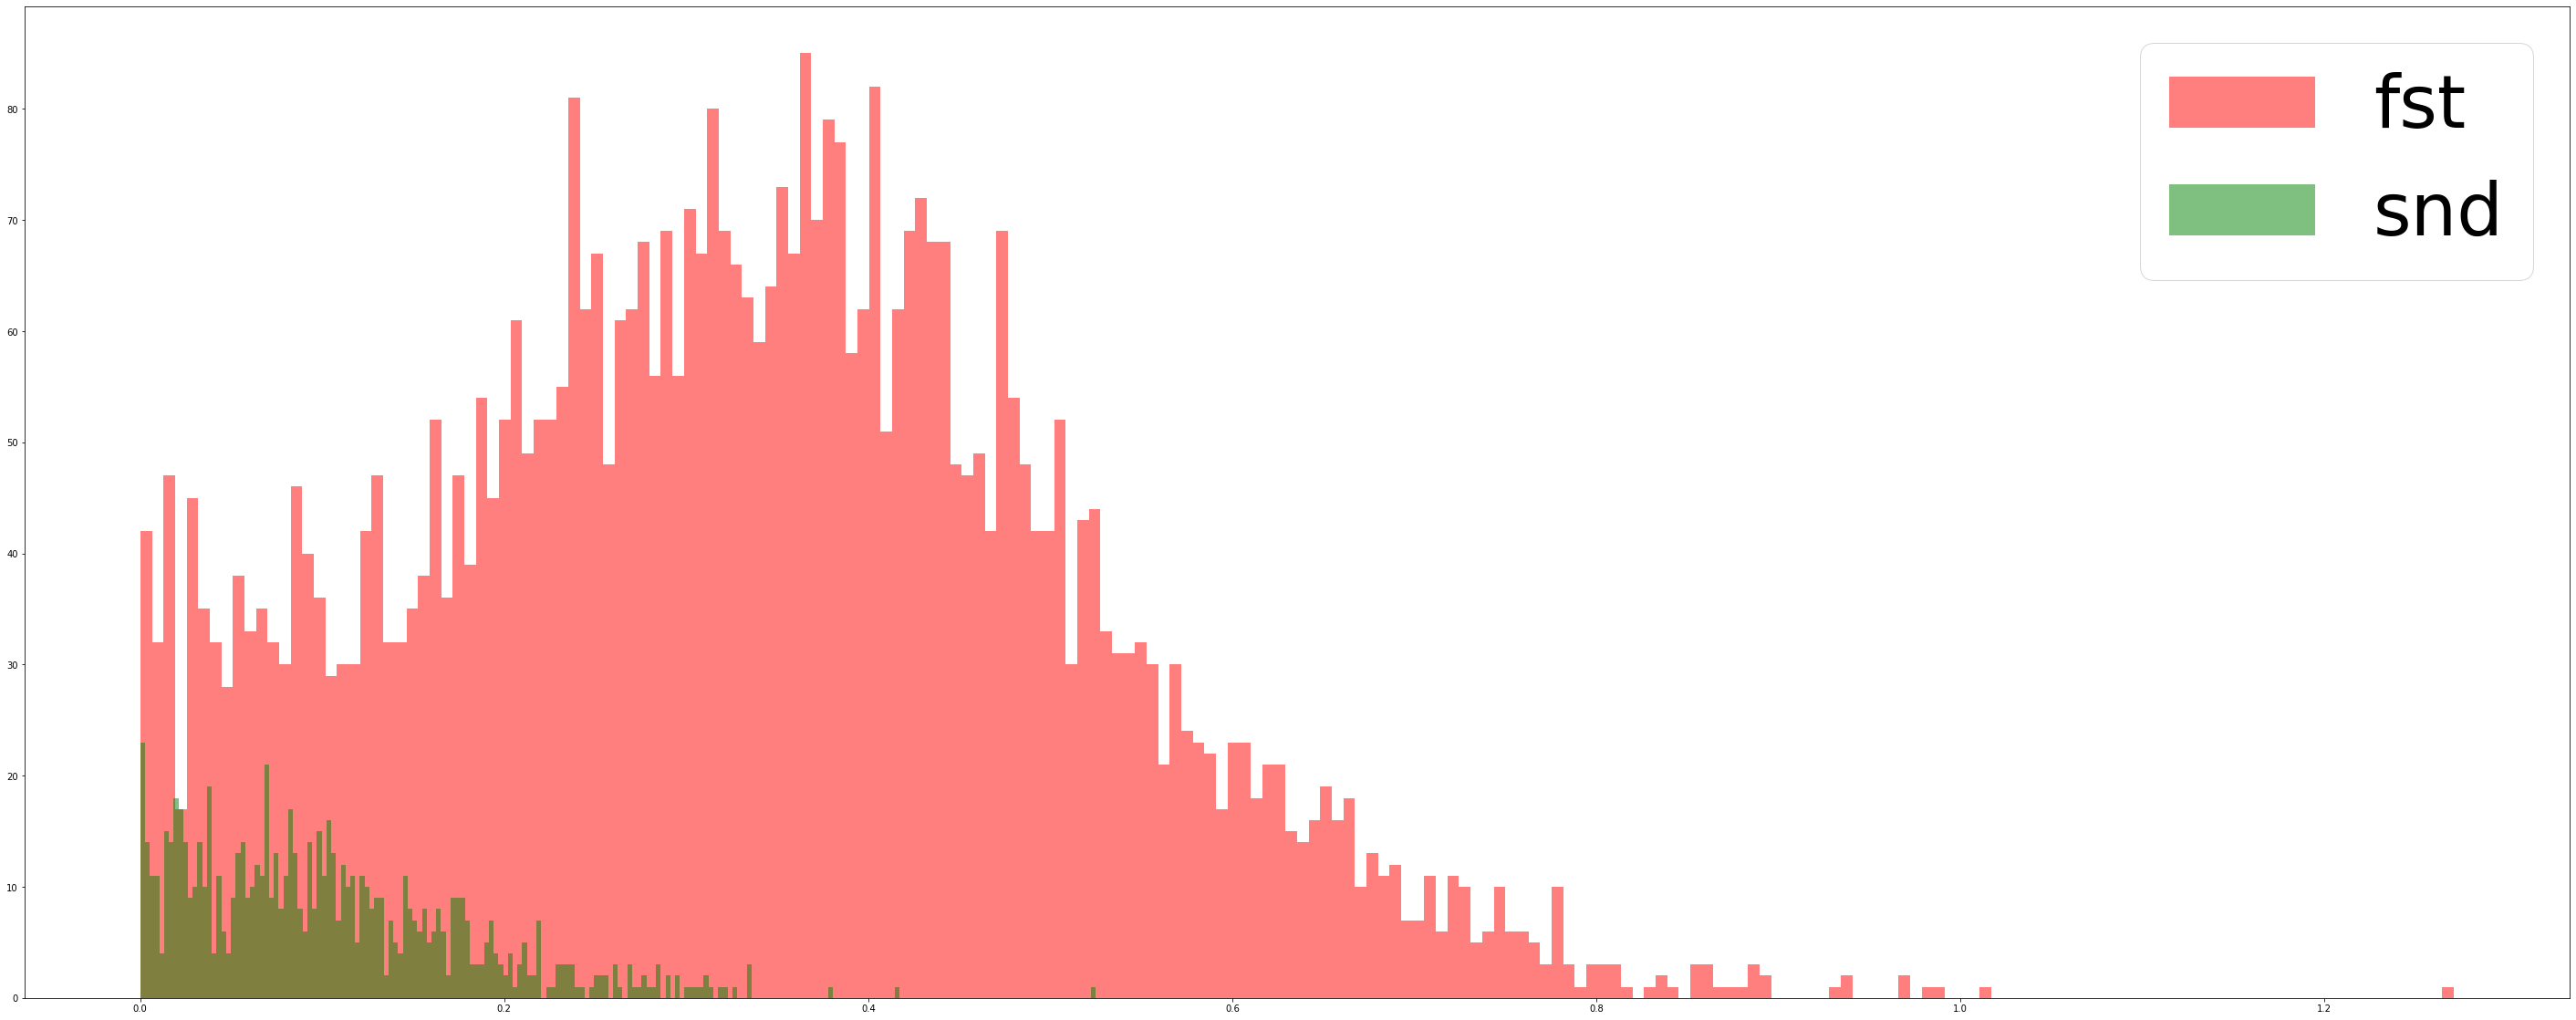

In [26]:
fst_scs, snd_scs = hdc.analyze(trainencoded, trainlabels)
print("Len of fst, snd: ",len(fst_scs), len(snd_scs))

new_fst = []
beta = np.max(snd_scs[:,0]/snd_scs[:,1])
for sc in fst_scs:
    if sc[0]/sc[1] <= beta:
        new_fst.append(sc)
fst_scs = np.asarray(new_fst)

print("Len of fst after cropping: ",len(fst_scs))

show_plots(fst_scs, snd_scs)

In [21]:
dominance = 1.2
hdc.make_mask(trainencoded, trainlabels, dominance)

Len of fst, snd:  657 526


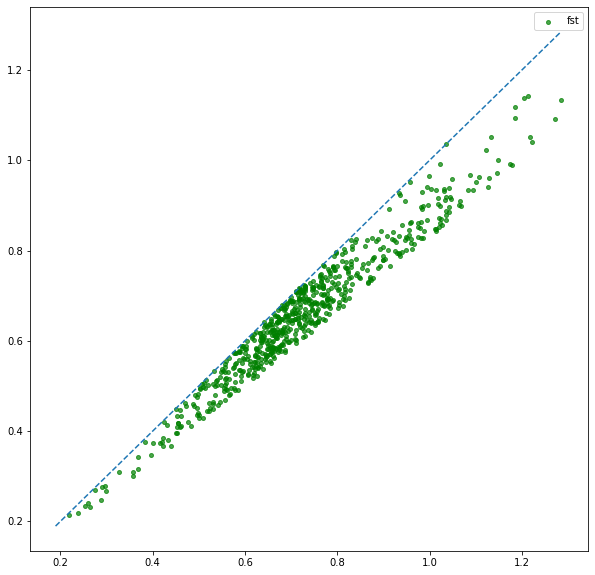

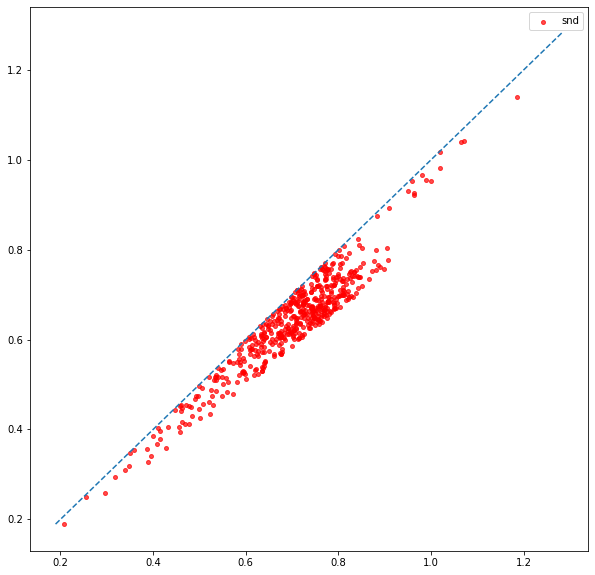

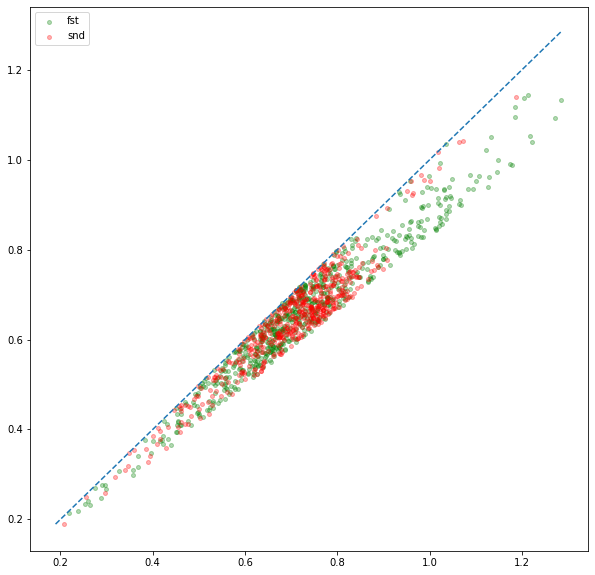

0.057732300787497505 1.094980610776924


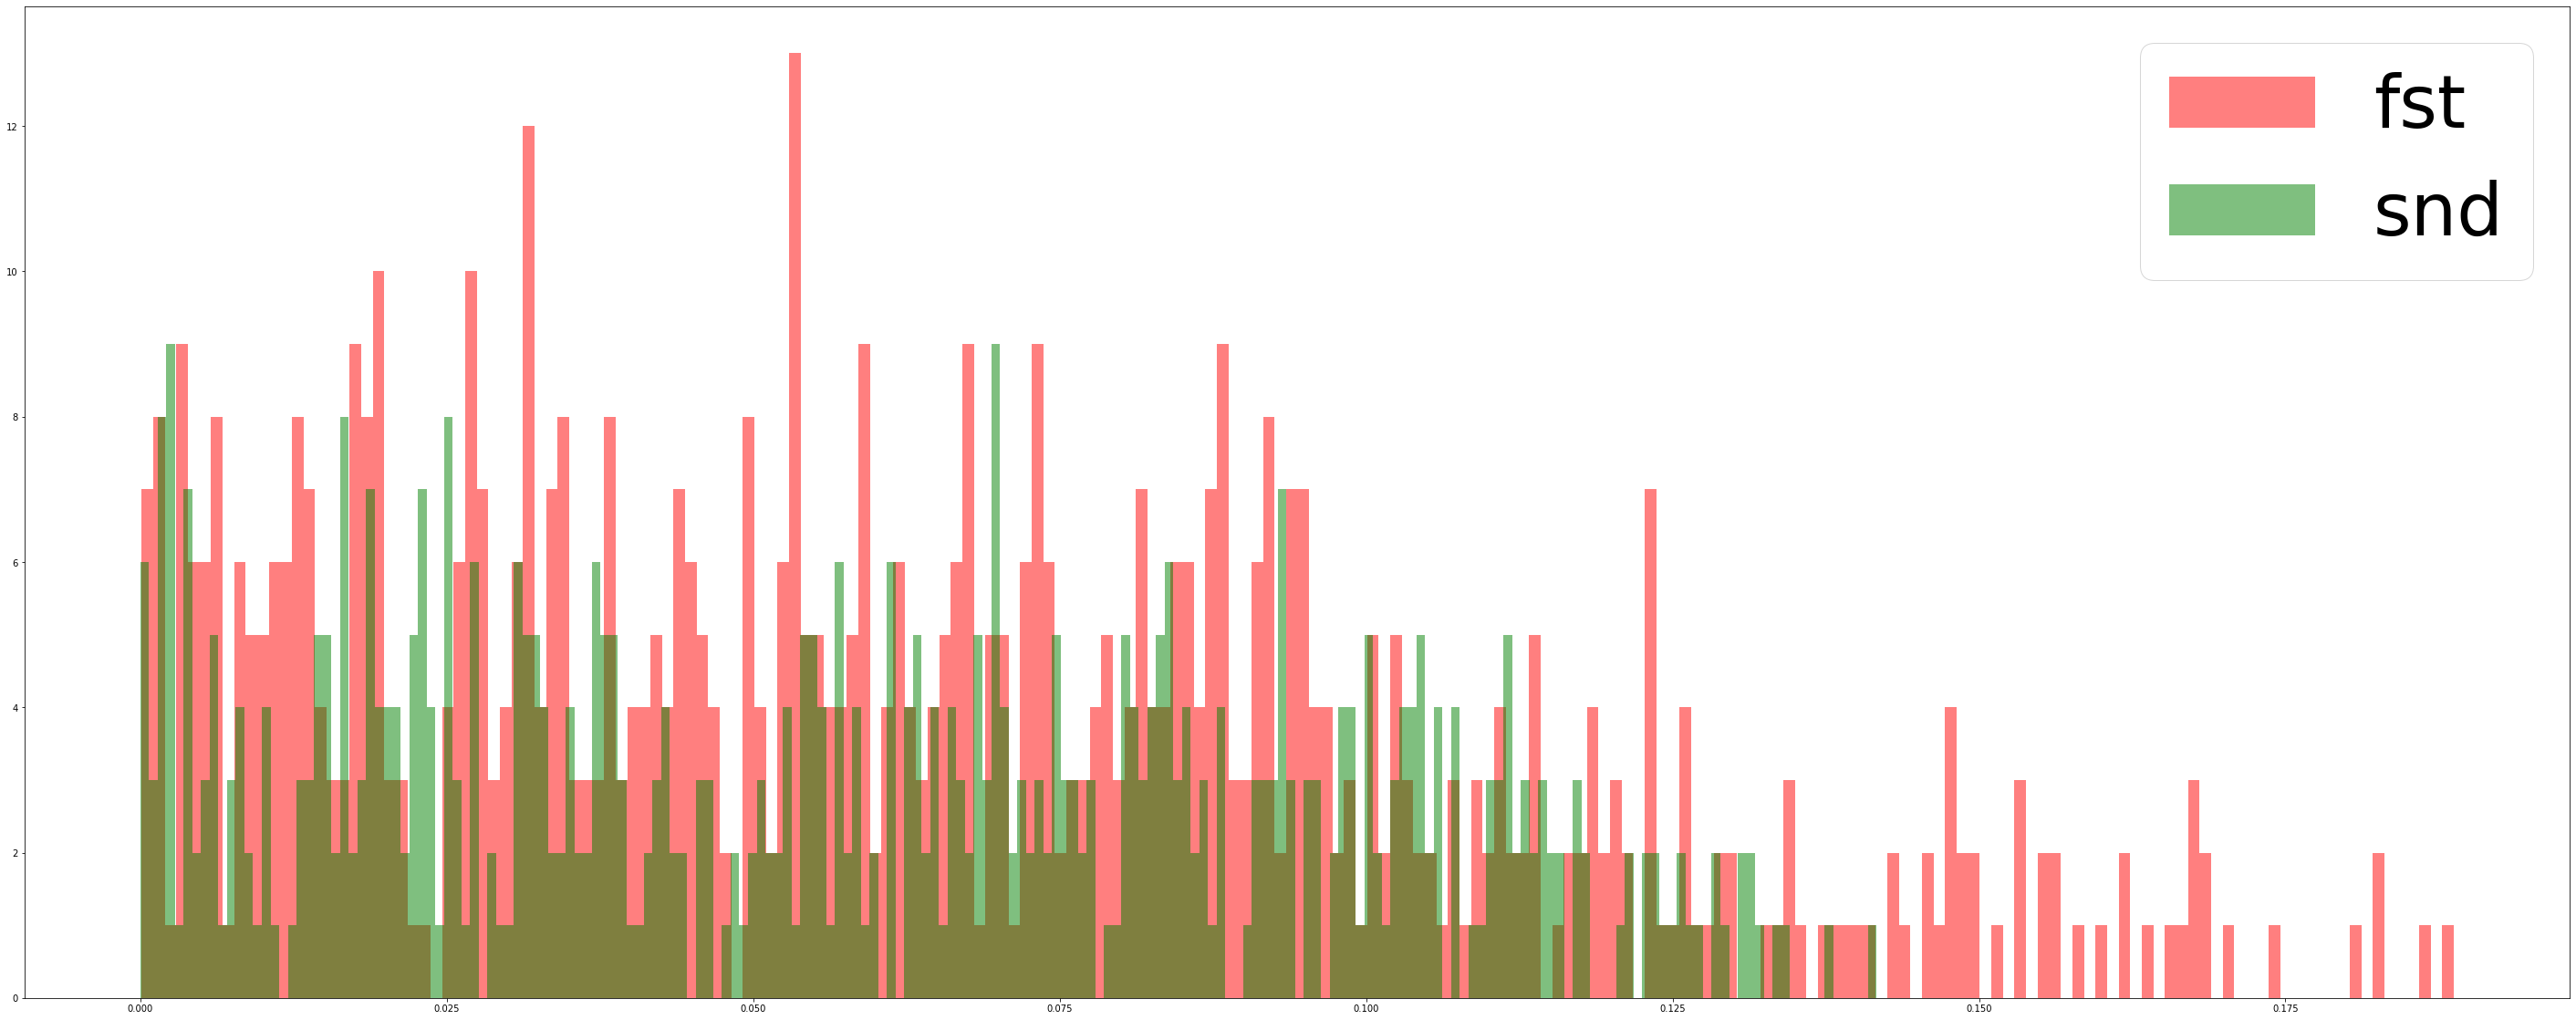

In [27]:
fst_scs, snd_scs = hdc.analyze(trainencoded, trainlabels, dominance)
print("Len of fst, snd: ",len(fst_scs), len(snd_scs))
show_plots(fst_scs, snd_scs)

In [23]:
percent = 0.5
hdc.prep_mask(percent)

Analyzing score with mask type b 2
Length fss, snd:  657 516


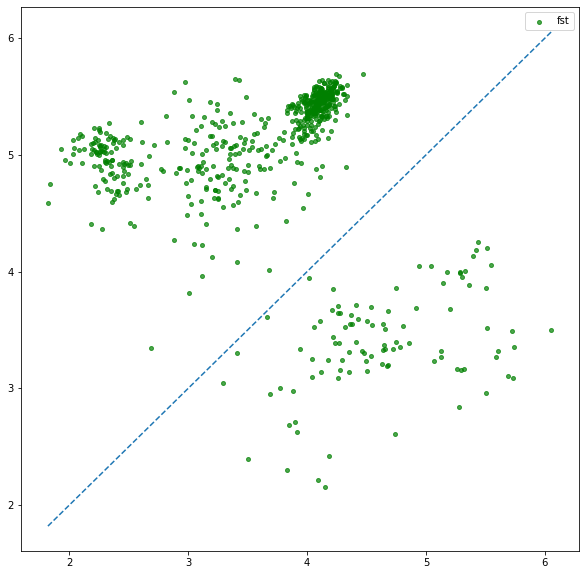

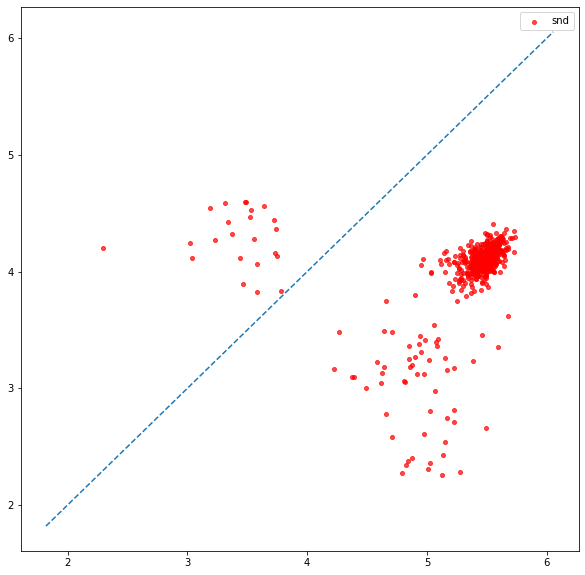

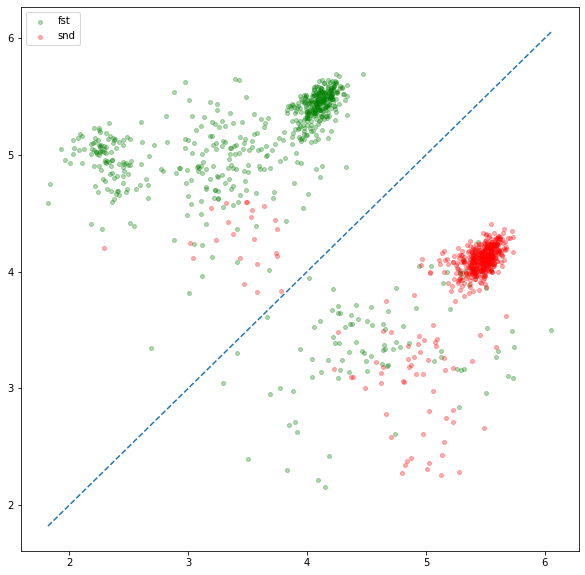

0.3709658286499325 1.03066631748394


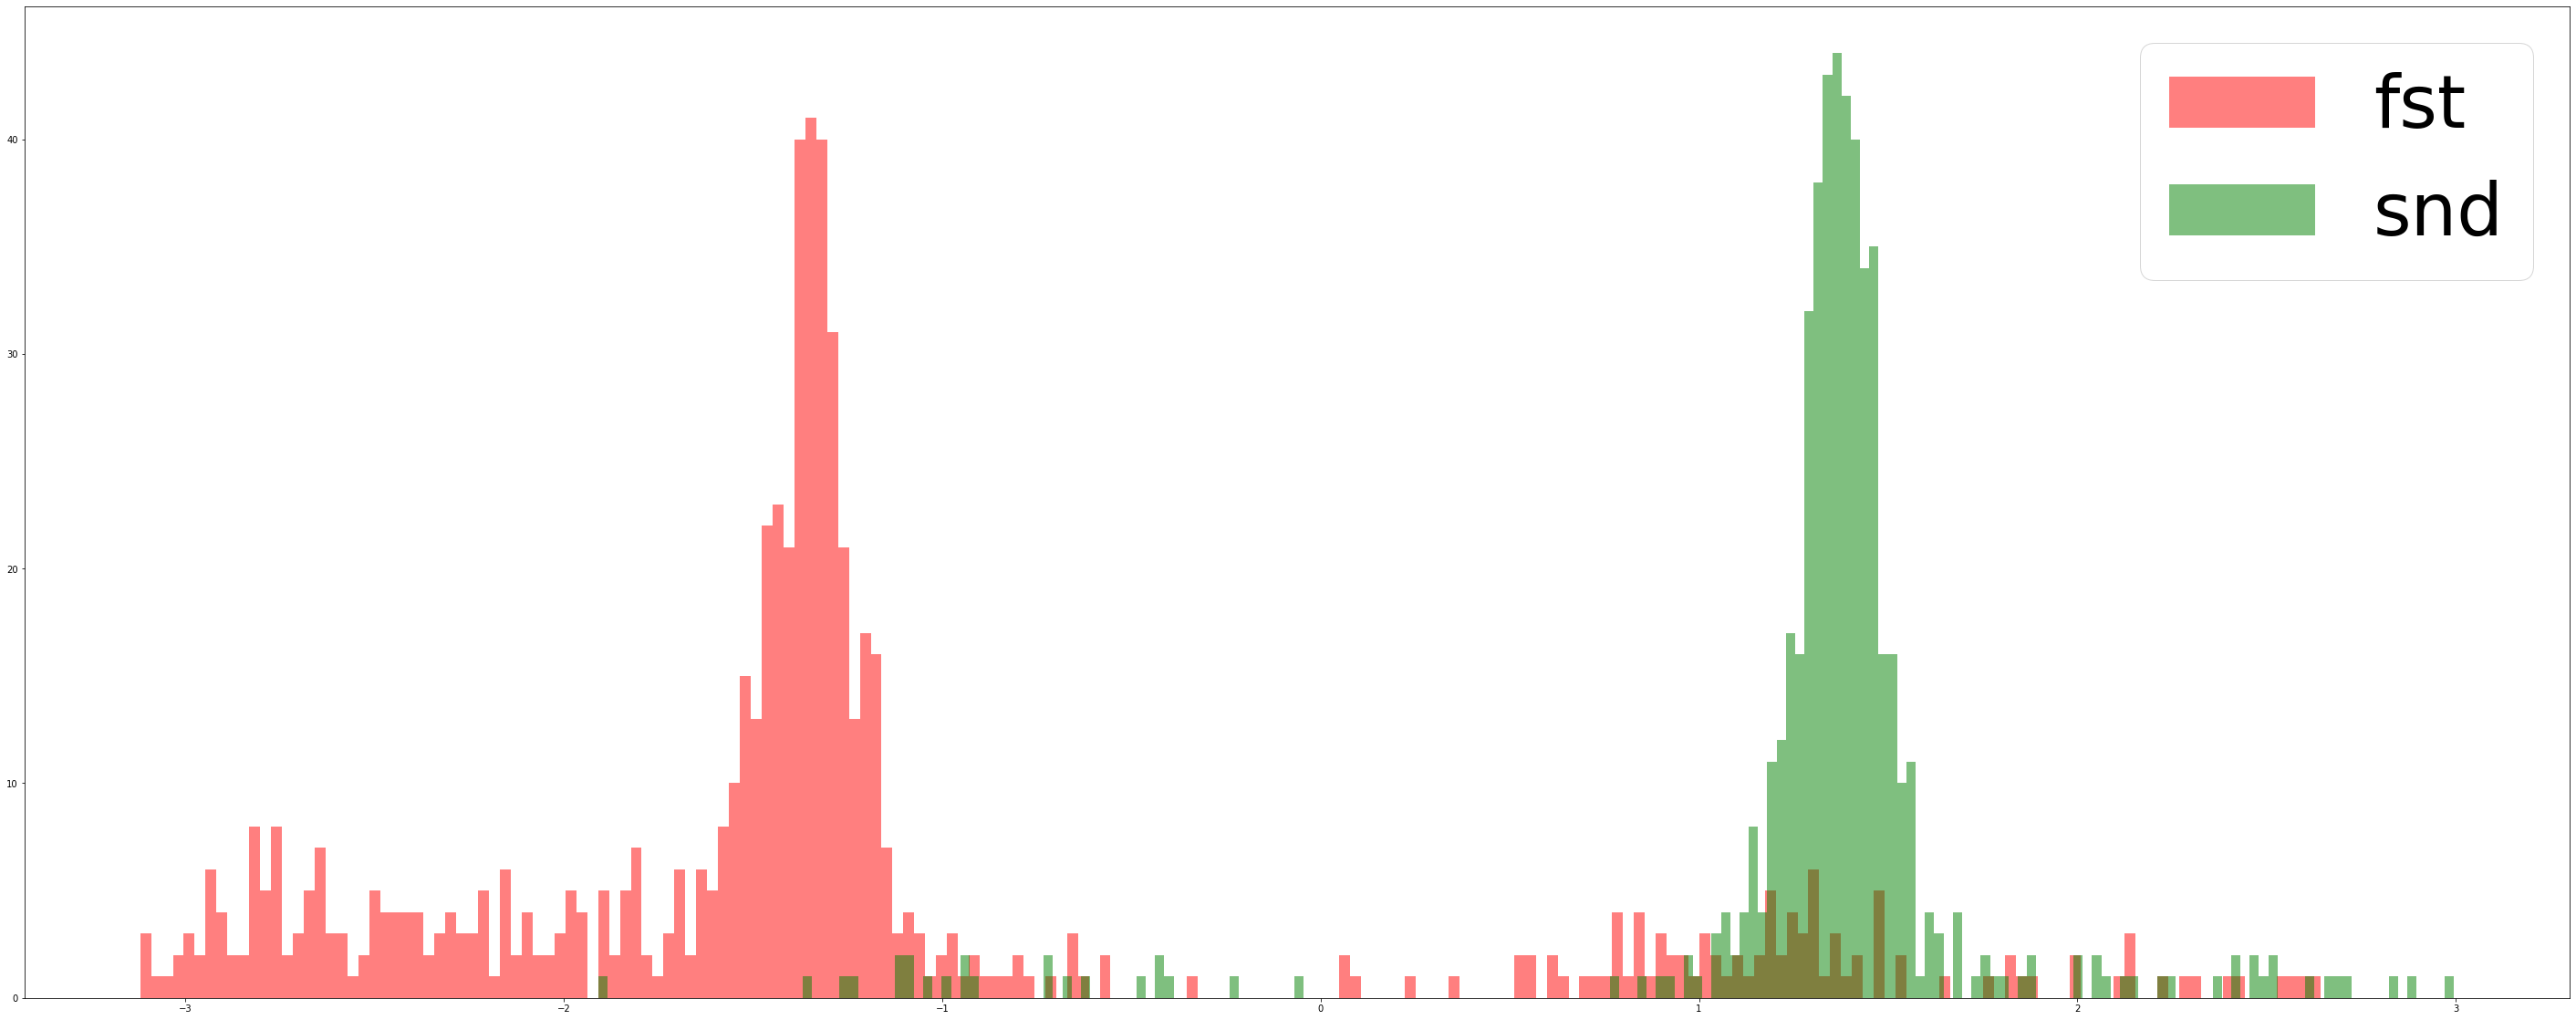

In [28]:
mask_t = "b" # b for binary, o for original 
mask_d = 2
threshold = 0.3
hdc.set_decider(trainencoded, trainlabels, threshold, dominance, mask_t, mask_d)
fst_scs, snd_scs = hdc.analyze_topn(trainencoded, trainlabels, dominance, mask_t, mask_d)
print("Length fss, snd: ", len(fst_scs), len(snd_scs))
show_plots(fst_scs, snd_scs)

In [11]:
def evaluate(func, data, labels, threshold, dominance, mask_t, mask_d):
    correct, c_1, c_2, c_r, w_1, w_2, w_3, count, mat, net_mat = func(data, labels, threshold, dominance, mask_t, mask_d)
    print("Accuracy: ", correct/count)
    print("Original: ", c_1/count)
    print("Correct: ",correct)
    print("First is Correct: ", c_1)
    print("Wrong second is selected: ", w_1)
    print("Second is Correct: ", c_2)
    print("Correct Second is selected: ", c_r)
    print("Wrong first is selected: ", w_2)
    print("Out of top 2: ", w_3)
    print("Net increase in correct cases and accuracy: ", c_r-w_1, (c_r-w_1)/count)
    print("Potential increase in correct cases and accuracy: ", c_2, c_2/count)
    print("Total cases:", count)
    print("Confusion Matrix:\n", mat)
    print("Net correct Matrix:\n", net_mat)

In [12]:
def try_hp(hdc, curr_config, data, labels):
    
    global dominances, percents, thresholds
    
    mask_t = "b" # b for binary, o for original 
    mask_d = 2
    i, j, k = curr_config
    print(i, j, k)
    (dominance, percent, threshold) = dominances[i], percents[j], thresholds[k]
    
    hdc.make_mask(data, labels, dominance)
    hdc.prep_mask(percent)
    hdc.set_decider(data, labels, threshold, dominance, mask_t, mask_d)

    print("########################### TEST MASK REVEAL ################################")
    evaluate(hdc.test_mask, data, labels, threshold, dominance, mask_t, mask_d)

    print("########################### TEST DECIDER REVEAL ################################")
    evaluate(hdc.test_decider, data, labels, threshold, dominance, mask_t, mask_d)

In [13]:
dominances = [1.1, 1.3, 1.5, 1.7]
percents = [0.2, 0.5, 0.8]
thresholds = [0.2, 0.3, 0.5]

def hp_tuning(hdc, data, labels):
    
    global dominances, percents, thresholds
    
    best_mk_acc = 0
    best_mk_config = (0, 0, 0)
    
    best_dc_acc = 0
    best_dc_config = (0, 0, 0)
    
    mask_t = "b" # b for binary, o for original 
    mask_d = 2
    
    og_acc = 0
    op_acc = 0
    mk_accs = np.zeros((len(dominances), len(percents), len(thresholds)))
    dc_accs = np.zeros((len(dominances), len(percents), len(thresholds)))
    
    for i, dominance in enumerate(dominances):
        hdc.make_mask(data, labels, dominance)
        for j, percent in enumerate(percents):
            hdc.prep_mask(percent)
            
            for k, threshold in enumerate(thresholds):
                hdc.set_decider(data, labels, threshold, dominance, mask_t, mask_d)

                #fst_scs, snd_scs = hdc.analyze_topn(data, labels, dominance, mask_t, mask_d)
                #print("Length fss, snd: ", len(fst_scs), len(snd_scs))
                #show_plots(fst_scs, snd_scs)

                correct, c_1, c_2, c_r, w_1, w_2, w_3, count, mat, net_mat = \
                    hdc.test_mask(data, labels, threshold, dominance, mask_t, mask_d)
                og_acc =  c_1/count
                op_acc =  (c_1 + c_2)/count
                mk_accs[i,j,k] = correct/count
                correct, c_1, c_2, c_r, w_1, w_2, w_3, count, mat, net_mat = \
                    hdc.test_decider(data, labels, threshold, dominance, mask_t, mask_d)
                dc_accs[i,j,k] = correct/count
    
                # BEST MASK
                if mk_accs[i,j,k] > best_mk_acc:
                    best_mk_acc = mk_accs[i,j,k]
                    best_mk_config = (i,j,k)

                # BEST DECIDER 
                if dc_accs[i,j,k] > best_dc_acc:
                    best_dc_acc = dc_accs[i,j,k]
                    best_dc_config = (i,j,k)
                  
    print("Original Accuracy:", og_acc)
    print("Optimal mask at", best_mk_config, " with train accuracy", best_mk_acc)
    print("Optimal decider at", best_dc_config, " with train accuracy", best_dc_acc)
    print("Ideal Accuracy:", op_acc)
                
    return og_acc, op_acc, mk_accs, dc_accs, best_mk_config, best_dc_config
            

In [14]:
og_acc, op_acc, mk_accs, dc_accs, best_mk_config, best_dc_config = hp_tuning(hdc, trainencoded, trainlabels)

C:\HDComputing\TopnHD\HD_classifier.py:572: RuntimeWarning: invalid value encountered in true_divide
  rate = net_mat/mat


Original Accuracy: 0.8691453404152584
Optimal mask at (0, 1, 0)  with train accuracy 0.8221471108965073
Optimal decider at (1, 0, 0)  with train accuracy 0.9623370352486721
Ideal Accuracy: 0.9967809431836472


In [15]:
print("Original accu:", og_acc)
print("Optimal mask at", best_mk_config, " with train accuracy", np.max(mk_accs))
print("Optimal decider at", best_dc_config, " with train accuracy", np.max(dc_accs))
print("Ideal/Top 2 accu:", op_acc)
print("Mask Accs:\n", mk_accs)
print("Decider Accs:\n", dc_accs)

Original accu: 0.8691453404152584
Optimal mask at (0, 1, 0)  with train accuracy 0.8221471108965073
Optimal decider at (1, 0, 0)  with train accuracy 0.9623370352486721
Ideal/Top 2 accu: 0.9967809431836472
Mask Accs:
 [[[0.81908901 0.81908901 0.81908901]
  [0.82214711 0.82214711 0.82214711]
  [0.82214711 0.82214711 0.82214711]]

 [[0.72605826 0.72605826 0.72605826]
  [0.73442781 0.73442781 0.73442781]
  [0.73394495 0.73394495 0.73394495]]

 [[0.61870272 0.61870272 0.61870272]
  [0.63061323 0.63061323 0.63061323]
  [0.63013037 0.63013037 0.63013037]]

 [[0.53468534 0.53468534 0.53468534]
  [0.54756156 0.54756156 0.54756156]
  [0.54723966 0.54723966 0.54723966]]]
Decider Accs:
 [[[0.91002736 0.91002736 0.91051022]
  [0.91083213 0.91083213 0.91131498]
  [0.91083213 0.91083213 0.91131498]]

 [[0.96233704 0.96233704 0.95750845]
  [0.96217608 0.96217608 0.96185418]
  [0.96201513 0.96201513 0.96169322]]

 [[0.95203605 0.95139224 0.95074843]
  [0.95509416 0.95509416 0.95396749]
  [0.95509416 0

In [16]:
try_hp(hdc, best_mk_config, testencoded, testlabels)

0 1 0
########################### TEST MASK REVEAL ################################
Accuracy:  0.8088803088803089
Original:  0.8577863577863578
Correct:  1257
First is Correct:  1333
Wrong second is selected:  81
Second is Correct:  207
Correct Second is selected:  5
Wrong first is selected:  202
Out of top 2:  14
Net increase in correct cases and accuracy:  -76 -0.0489060489060489
Potential increase in correct cases and accuracy:  207 0.13320463320463322
Total cases: 1554
Confusion Matrix:
 [[ 0. 11.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [12.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  5.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 57.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 50.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0

In [17]:
try_hp(hdc, best_dc_config, testencoded, testlabels)

1 0 0
########################### TEST MASK REVEAL ################################
Accuracy:  0.7239382239382239
Original:  0.8577863577863578
Correct:  1125
First is Correct:  1333
Wrong second is selected:  215
Second is Correct:  207
Correct Second is selected:  7
Wrong first is selected:  200
Out of top 2:  14
Net increase in correct cases and accuracy:  -208 -0.13384813384813385
Potential increase in correct cases and accuracy:  207 0.13320463320463322
Total cases: 1554
Confusion Matrix:
 [[  0.  15.  11.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 38.   0.  12.   0.   0.   0.   3.   0.   0.   0.   0.   1.]
 [ 19.  16.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0. 132.   4.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  81.   0.   0.   2.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  62.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   

In [19]:
print(hdc.test(testencoded, testlabels))

0.8577863577863578


# Scratch Paper

In [1]:
# Select two classes to separate
cl1 = 3
cl2 = 4

ncl1 = 0
cl1_sum = np.zeros(hdc.D)
for sc in fst_scs:
    if sc[3] == cl1 and sc[4] == cl2:
        cl1_sum += trainencoded[int(sc[2])]
        ncl1 += 1
for sc in snd_scs:
    if sc[3] == cl2 and sc[4] == cl1:
        cl1_sum += trainencoded[int(sc[2])]
        ncl1 += 1 
ncl2 = 0
cl2_sum = np.zeros(hdc.D)
for sc in fst_scs:
    if sc[3] == cl2 and sc[4] == cl1:
        cl2_sum += trainencoded[int(sc[2])]
        ncl2 += 1
for sc in snd_scs:
    if sc[3] == cl1 and sc[4] == cl2:
        cl2_sum += trainencoded[int(sc[2])]
        ncl2 += 1
print("Component-wise sum of data points, sum1 sum2")
#print(cl1_sum)
#print(cl2_sum)

#print("Component-wise ratio sum1:sum2")
#print(cl1_sum/cl2_sum)
cl1_nm = sklearn.preprocessing.normalize(np.asarray([cl1_sum]), norm='l2')[0]
cl2_nm = sklearn.preprocessing.normalize(np.asarray([cl2_sum]), norm='l2')[0]
print("Component-wise normalized ratio normed(sum1):normed(sum2)")
print(cl1_nm/cl2_nm)
#print("Component-wise normalized diff normed(sum1) - normed(sum2)")
#print(cl1_nm - cl2_nm)

NameError: name 'np' is not defined

In [ ]:
og_mask1 = copy.deepcopy(hdc.mask2d[cl1][cl2])
og_mask2 = copy.deepcopy(hdc.mask2d[cl2][cl1])
hdc.mask2d[cl1][cl2] = mask
hdc.mask2d[cl2][cl1] = -mask

In [ ]:
hdc.mask2d[cl1][cl2] = og_mask1
hdc.mask2d[cl2][cl1] = og_mask2

In [ ]:
np.set_printoptions(linewidth=85, suppress = True)
fst_mat = np.zeros((hdc.nClasses, hdc.nClasses))
for sc in fst_scs:
    fst_mat[int(sc[3]), int(sc[4])] += 1

snd_mat = np.zeros((hdc.nClasses, hdc.nClasses))
for sc in snd_scs:
    snd_mat[int(sc[3]), int(sc[4])] += 1
print("fst confusion matrix: top 2 choices (row, col) whose answer is first choice")
print(fst_mat)
print("snd confusion matrix: top 2 choices (row, col) whose answer is second choice")
print(snd_mat)

In [ ]:
fst_r, snd_r = hdc.analyze(testencoded, testlabels)

print(len(fst_r), len(snd_r))
#beta = max(snd_r)
#fst_r = fst_r[fst_r <= beta]
print(len(fst_r))

fst_mr, snd_mr, fst_scs, snd_scs = hdc.analyze_topn(testencoded, testlabels, dominance, mask_t, mask_d)

print(len(fst_mr), len(snd_mr))
print(len(fst_scs), len(snd_scs))
#print(fst_mr)
#print(snd_mr)
#print(fst_scs)
#print(snd_scs)


plt.figure(figsize = (100, 20))
plt.hist(np.append(fst_mr,snd_mr), bins = 1000, label = "fst")
plt.hist(snd_mr, bins = 1000, label = "snd")
plt.legend()

plt.figure(figsize = (100, 20))
plt.hist(np.append(fst_scs,snd_scs), bins = 1000, label = "fst")
plt.hist(snd_scs, bins = 1000, label = "snd")
plt.legend()

In [21]:
np.set_printoptions(threshold=sys.maxsize)